**迁移学习（Transfer Learning）**，不从随机参数开始训练一个神经网络，而是用预训练（pretrained）好权重的神经网络为基础，进行学习。所谓的”站在巨人的肩膀上“。
本例使用已经在ImageNet（120万张图片、1000个类别）上训练好的网络，并且不改变该网络权重，替换最后的全连接层，对全连接层的参数进行学习。最终实现区分蚂蚁和蜜蜂的效果。

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()  # 交互模式

# 训练方式 CPU/CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# 加载数据
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 随机裁剪
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


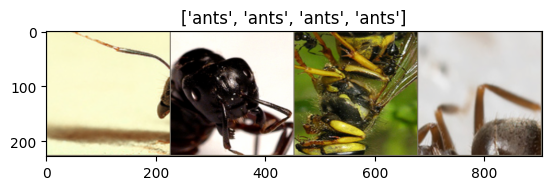

In [3]:
# 训练数据可视化
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
# 训练/测试函数
# lr_scheduler
# 保存最好的模型权重
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
# 模型预测 以及 可视化
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
from torchvision.models import ResNet18_Weights

# 加载预训练模型
model_ft = models.resnet18(weights=ResNet18_Weights.DEFAULT)
# 修改最后的全连接层，使得输出特征为2（分类数目）
num_in = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_in, 2)

model_ft = model_ft.to(device)

In [7]:
# 损失函数、优化器、LR scheduler
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
# 训练
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6075 Acc: 0.7049
val Loss: 0.1782 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4501 Acc: 0.8074
val Loss: 0.2573 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4128 Acc: 0.8320
val Loss: 0.1749 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4709 Acc: 0.8238
val Loss: 0.4430 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.6146 Acc: 0.7705
val Loss: 0.4131 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.7609 Acc: 0.7664
val Loss: 0.5389 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.5386 Acc: 0.7951
val Loss: 0.5783 Acc: 0.8235

Epoch 7/24
----------
train Loss: 0.4585 Acc: 0.8156
val Loss: 0.3014 Acc: 0.8627

Epoch 8/24
----------
train Loss: 0.3332 Acc: 0.8361
val Loss: 0.2458 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3442 Acc: 0.8566
val Loss: 0.2384 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3433 Acc: 0.8607
val Loss: 0.2188 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2969 Acc: 0.8852
val Loss: 0.2229 Acc: 0.9085

Ep

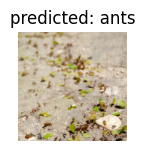

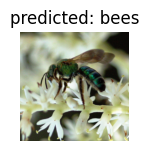

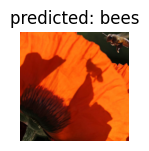

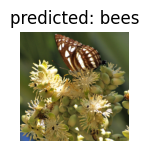

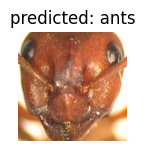

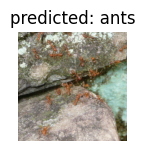

In [9]:
visualize_model(model_ft)

plt.ioff()
plt.show()